In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv(r"C:\Users\sheet\Dropbox\PC\Downloads\sentiment_tweets3.csv")
dataset

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [3]:
dataset.head(5)

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [4]:
dataset.info

<bound method DataFrame.info of        Unnamed: 0                                            message  label
0             106  just had a real good moment. i missssssssss hi...      0
1             217         is reading manga  http://plurk.com/p/mzp1e      0
2             220  @comeagainjen http://twitpic.com/2y2lx - http:...      0
3             288  @lapcat Need to send 'em to my accountant tomo...      0
4             540      ADD ME ON MYSPACE!!!  myspace.com/LookThunder      0
...           ...                                                ...    ...
10309      802309  No Depression by G Herbo is my mood from now o...      1
10310      802310  What do you do when depression succumbs the br...      1
10311      802311  Ketamine Nasal Spray Shows Promise Against Dep...      1
10312      802312  dont mistake a bad day with depression! everyo...      1
10313      802313                                                  0      1

[10314 rows x 3 columns]>

In [5]:
dataset.columns

Index(['Unnamed: 0', 'message', 'label'], dtype='object')

In [6]:
# Dropping column "unnamed"
dataset = dataset.drop('Unnamed: 0',axis=1)

In [7]:
dataset.head(5)

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [8]:
dataset.shape

(10314, 2)

In [9]:
# check non-depressive tweets
dataset[dataset["label"]==0].message.head()

0    just had a real good moment. i missssssssss hi...
1           is reading manga  http://plurk.com/p/mzp1e
2    @comeagainjen http://twitpic.com/2y2lx - http:...
3    @lapcat Need to send 'em to my accountant tomo...
4        ADD ME ON MYSPACE!!!  myspace.com/LookThunder
Name: message, dtype: object

In [10]:
# check depressive tweets
dataset[dataset["label"] == 1].message.head()

8000    The lack of this understanding is a small but ...
8001    i just told my parents about my depression and...
8002    depression is something i don't speak about ev...
8003    Made myself a tortilla filled with pb&j. My de...
8004    @WorldofOutlaws I am gonna need depression med...
Name: message, dtype: object

## Create a new column called "text length" which is the number of words in the text column.

In [11]:
dataset['text length'] = dataset['message'].apply(len)
dataset.head()

,message,label,text length
0,just had a real good moment. i missssssssss hi...,0,57
1,is reading manga http://plurk.com/p/mzp1e,0,42
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,84
3,@lapcat Need to send 'em to my accountant tomo...,0,135
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,45


In [12]:
dataset.describe()

,label,text length
count,10314.000000,10314.000000
mean,0.224355,91.869401
std,0.417177,61.818926
min,0.000000,1.000000
25%,0.000000,48.000000
50%,0.000000,78.000000
75%,0.000000,119.000000
max,1.000000,612.000000


## Visualizing Data

### Create a countplot of the number of occurrences for each type label.

Text(0.5, 1.0, 'Dataset distribution')

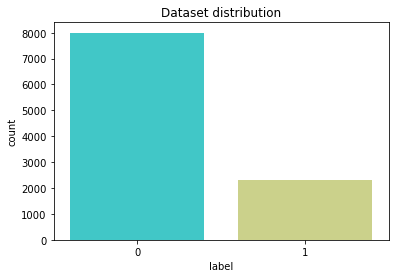

In [13]:
ax = sns.countplot(x="label", data=dataset,palette='rainbow')
ax.set_title('Dataset distribution')

## CLEANING DATA

In [14]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
corpus = []
for i in range(0,10314):
    tweet = dataset['message'][i]
    tweet = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', ' ', tweet) # remove urls
    tweet = re.sub(r'#', '', tweet) # remove hashtag symbol
    tweet = re.sub(r'<([^>]*)>', ' ', tweet) # remove emojis
    tweet = re.sub('[^a-zA-Z]',' ', tweet) 
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

In [16]:
corpus[:50]

['real good moment missssssssss much',
 'read manga',
 'comeagainjen',
 'lapcat need send em account tomorrow oddli even refer tax support evid though',
 'add myspac myspac com lookthund',
 'sleepi good time tonight though',
 'silkcharm nbn someon alreadi said fiber home mean least regular',
 'c possibl today nice',
 'nite twittervil workout ciao',
 'danann night darlin sweet dream',
 'good morn everybodi',
 'final creat wordpress blog alreadi blog seattl coffe commun',
 'kisha cnt get u til get frm u rememb ur top',
 'nicolerichi ye rememb band awesom pleas repli',
 'realli love reflect shadow',
 'blueaero ooo fantasi like fantasi novel check',
 'rokchic prob sell noth blog get listen band itun',
 'shipovalov quot nokla connect peopl quot',
 'stay late start earli good thing like job',
 'kal penn read new job congratul fantast',
 'abl sleep think watch ugli betti onlin',
 'woo thank ron steev follow yeow folowerssss haha p wanna got ellen show',
 'aidenchan yeah sure sister take extra

In [17]:
# Creating dataframe of cleaned data
df = pd.DataFrame({'message':corpus, 'label':dataset['label']})
df.head(),df.tail()

(                                             message  label
 0                 real good moment missssssssss much      0
 1                                         read manga      0
 2                                       comeagainjen      0
 3  lapcat need send em account tomorrow oddli eve...      0
 4                    add myspac myspac com lookthund      0,
                                                  message  label
 10309      depress g herbo mood done stress peopl deserv      1
 10310  depress succumb brain make feel like never enough      1
 10311  ketamin nasal spray show promis depress suicid...      1
 10312             dont mistak bad day depress everyon em      1
 10313                                                         1)

## Word cloud visualization of Dataset

In [18]:
from wordcloud import WordCloud

In [19]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### For depression indicative texts

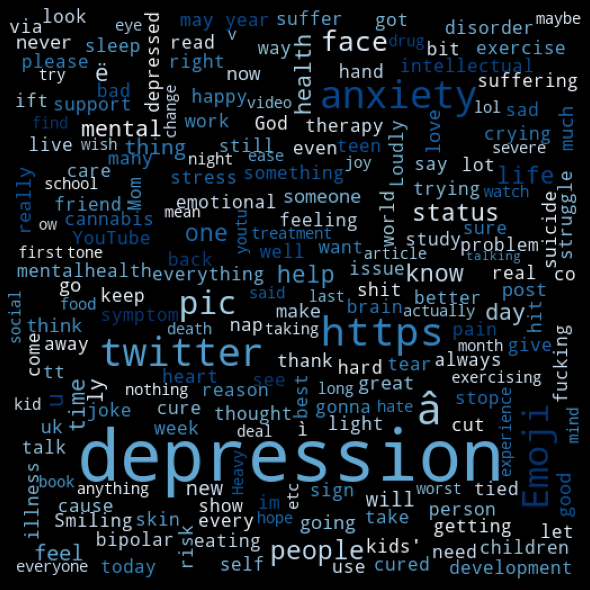

In [20]:
depressive_words = ' '.join(list(dataset[dataset['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


### For non-depression indicative texts

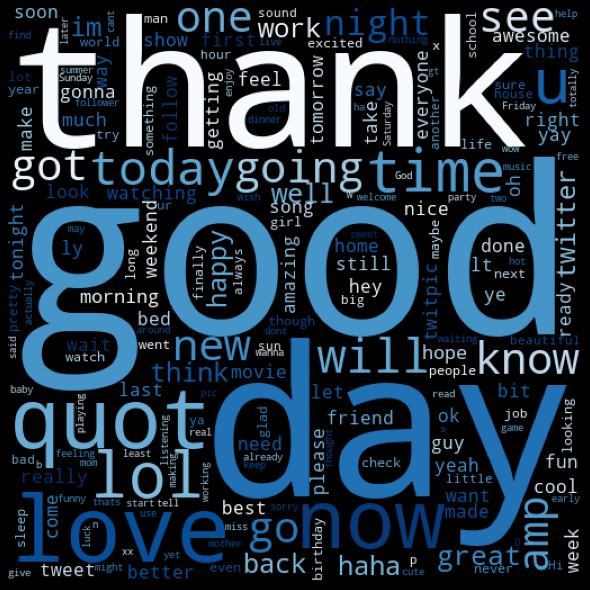

In [21]:
positive_words = ' '.join(list(dataset[dataset['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [22]:
#Creating Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
cv = CountVectorizer(max_features=600) #18153
X = cv.fit_transform(corpus).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
y = dataset['label']
y

0        0
1        0
2        0
3        0
4        0
        ..
10309    1
10310    1
10311    1
10312    1
10313    1
Name: label, Length: 10314, dtype: int64

### Splitting the dataset

In [25]:
from sklearn.model_selection import train_test_split
# Function for splitting dataset into training and testing dataset
def split_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0) 
    return (X_train, X_test, y_train, y_test)

In [26]:
X_train, X_test, y_train, y_test = split_dataset(X, y) 

## Implementing ML models

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

class Classifier:
    
    def __init__(self, X_train, y_train, classifier_name, n_neighbors = 1):
        self.X_train = X_train
        self.y_train = y_train
        # For naive bayes 
        if classifier_name == 'NB':
            self.classifier = GaussianNB()
        
        # For Random Forest
        if classifier_name == 'RF':
            self.classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
            
        # For SVM
        if classifier_name == 'SVM':
            self.classifier = SVC(kernel = 'linear', random_state = 0)
            
            
        self.classifier.fit(X_train,y_train)
        
    def predict(self, X_test):
        self.y_pred = self.classifier.predict(X_test)
        return self.y_pred
    
    def cf_matrix(self, y_test):
        self.cf = confusion_matrix(y_test, self.y_pred)
        return self.cf

In [28]:
# Function for calculation of evalution matrix
def metrics(labels, predictions, feature_name, model_name):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = (true_pos / (true_pos + false_pos))*100
    precision = round(precision, 2)
    recall = (true_pos / (true_pos + false_neg))*100
    recall = round(recall, 2)
    Fscore = (2 * precision * recall / (precision + recall))
    Fscore = round(Fscore,2)
    accuracy = ((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg))*100
    accuracy = round(accuracy,2)
    
    # Store result
    store_result((precision, recall, Fscore, accuracy), feature_name, model_name)
    
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [29]:
# Function for plotting confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
features = [ 'bow','tfidf', 'word2vec']
models = ['Naive Bayes', 'Random Forest', 'SVM']
d_accuracy = {}
d_precision = {}
d_recall = {}
d_fscore = {}

for feature in features:
    d_accuracy[feature] = {}
    for model in models:
        d_accuracy[feature][model] = 0

for feature in features:
    d_precision[feature] = {}
    for model in models:
        d_precision[feature][model] = 0

for feature in features:
    d_recall[feature] = {}
    for model in models:
        d_recall[feature][model] = 0
        
for feature in features:
    d_fscore[feature] = {}
    for model in models:
        d_fscore[feature][model] = 0

def store_result(metrics, feature_name, model):
    precision, recall, Fscore, accuracy = metrics
    d_accuracy[feature_name][model] = accuracy
    d_precision[feature_name][model] = precision
    d_fscore[feature_name][model] = Fscore
    d_recall[feature_name][model] = recall

### Naive Bayes

Precision:  41.83
Recall:  98.18
F-score:  58.67
Accuracy:  67.55


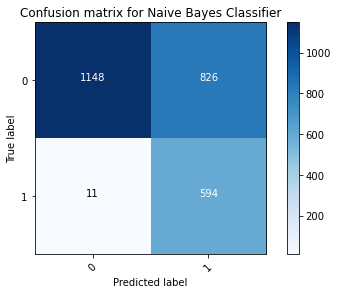

In [31]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'NB')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for Naive Bayes Classifier')
# Evalutation matrix
metrics(list(y_test),y_pred, 'bow', 'Naive Bayes')

### Random Forest

Precision:  99.83
Recall:  98.51
F-score:  99.17
Accuracy:  99.61


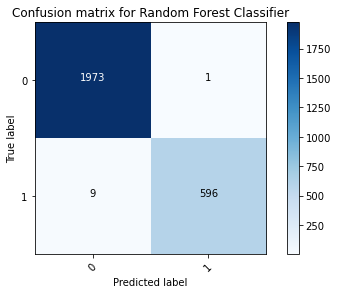

In [32]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'RF')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for Random Forest Classifier')
# Evalutation matrix
metrics(list(y_test),y_pred, 'bow', 'Random Forest')

### Support VectorMachine

Precision:  100.0
Recall:  98.18
F-score:  99.08
Accuracy:  99.57


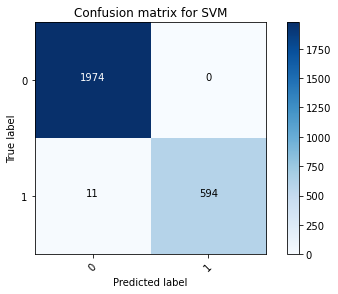

In [33]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'SVM')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for SVM')
# Evalutation matrix
metrics(list(y_test),y_pred, 'bow', 'SVM')

### Using Text Classifier - TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer

X_tfidf = TfidfTransformer().fit_transform(X).toarray()

In [35]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
y

0        0
1        0
2        0
3        0
4        0
        ..
10309    1
10310    1
10311    1
10312    1
10313    1
Name: label, Length: 10314, dtype: int64

### Splitting the dataset

In [37]:
X_train, X_test, y_train, y_test = split_dataset(X_tfidf, y) 

## Implement Classification Models

### Naive Bayes

Precision:  43.79
Recall:  97.85
F-score:  60.5
Accuracy:  70.03


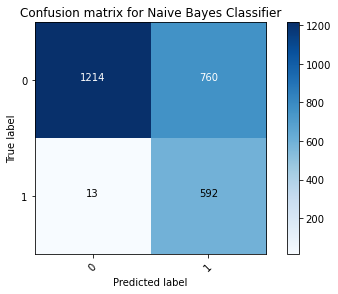

In [38]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'NB')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for Naive Bayes Classifier')
# Evalutation matrix
metrics(list(y_test),y_pred, 'tfidf', 'Naive Bayes')

### Random Forest

Precision:  100.0
Recall:  98.18
F-score:  99.08
Accuracy:  99.57


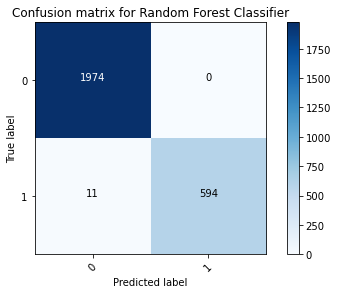

In [39]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'RF')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for Random Forest Classifier')
# Evalutation matrix
metrics(list(y_test),y_pred, 'tfidf', 'Random Forest')

### Support Vector Machine

Precision:  100.0
Recall:  98.35
F-score:  99.17
Accuracy:  99.61


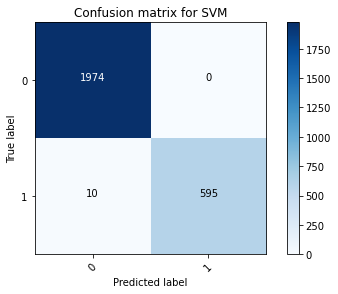

In [40]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'SVM')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for SVM')
# Evalutation matrix
metrics(list(y_test),y_pred, 'tfidf', 'SVM')

## Word Embedding

### Word2Vec

In [41]:
from gensim.models import KeyedVectors

class Word2VecVectorizer:
    def __init__(self):
        print("Loading in word vectors...")
        self.word_vectors = KeyedVectors.load_word2vec_format(r'C:\Users\sheet\Dropbox\PC\Downloads\python\GoogleNews-vectors-negative300.bin',binary=True)
        print("Finished loading in word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        # determine the dimensionality of vectors
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    # throws KeyError if word not found
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X


    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [42]:
pip install gensim==4.1.2

Note: you may need to restart the kernel to use updated packages.


In [43]:
vectorizer_w2v = Word2VecVectorizer()

Loading in word vectors...
Finished loading in word vectors


In [44]:
# Processing dataset using vectorizer_w2v
X_w2v = vectorizer_w2v.fit_transform(corpus)
y_w2v = dataset['label']

Numer of samples with no words found: 126 / 10314


### Splitting dataset

In [45]:
X_train, X_test, y_train, y_test = split_dataset(X_w2v, y_w2v)

## Implementing classification models

## Naive Bayes

Precision:  73.86
Recall:  96.69
F-score:  83.75
Accuracy:  91.2


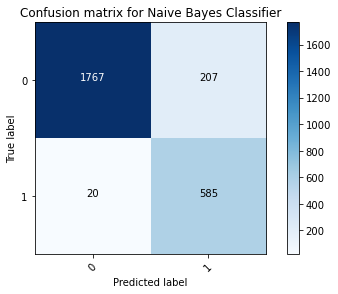

In [46]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'NB')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for Naive Bayes Classifier')
# Evalutation matrix
metrics(list(y_test),y_pred, 'word2vec', 'Naive Bayes')

## Random Forest

Precision:  99.2
Recall:  81.98
F-score:  89.77
Accuracy:  95.62


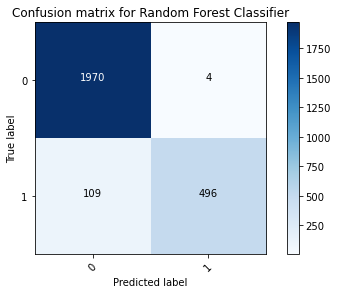

In [47]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'RF')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating classifier object
classifier = Classifier(X_train,y_train,'RF')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for Random Forest Classifier')
# Evalutation matrix
metrics(list(y_test),y_pred, 'word2vec', 'Random Forest')

## SVM

Precision:  94.63
Recall:  96.03
F-score:  95.32
Accuracy:  97.79


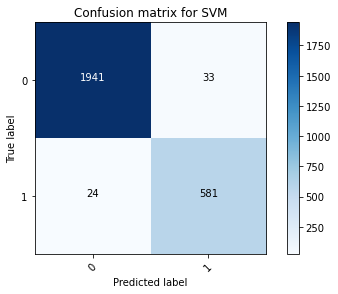

In [48]:
# Creating classifier object
classifier = Classifier(X_train,y_train,'SVM')
# Predicting y values
y_pred = classifier.predict(X_test)
# Creating and plotting confusion_matrix 
cf_matrix = classifier.cf_matrix(y_test)
plot_confusion_matrix(cf_matrix,classes=[0,1],title='Confusion matrix for SVM')
# Evalutation matrix
metrics(list(y_test),y_pred, 'word2vec', 'SVM')

## Visualizing Result

In [49]:
plt.style.use('ggplot')

                 bow  tfidf  word2vec
Naive Bayes    67.55  70.03     91.20
Random Forest  99.61  99.57     95.62
SVM            99.57  99.61     97.79


Text(0.5, 0, 'Features')

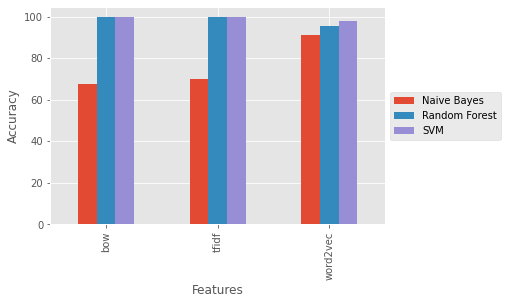

In [50]:
df_accuracy = pd.DataFrame(d_accuracy)
print(df_accuracy)

df_accuracy.transpose().plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Accuracy')
plt.xlabel('Features')
# plt.text()
# addlabels()

                 bow  tfidf  word2vec
Naive Bayes    98.18  97.85     96.69
Random Forest  98.51  98.18     81.98
SVM            98.18  98.35     96.03


Text(0.5, 0, 'Features')

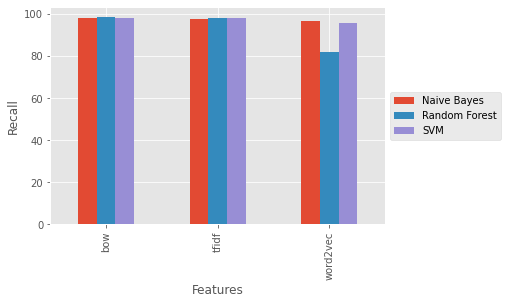

In [51]:
df_recall = pd.DataFrame(d_recall)
print(df_recall)

df_recall.transpose().plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Recall')
plt.xlabel('Features')

                 bow  tfidf  word2vec
Naive Bayes    58.67  60.50     83.75
Random Forest  99.17  99.08     89.77
SVM            99.08  99.17     95.32


Text(0.5, 0, 'Features')

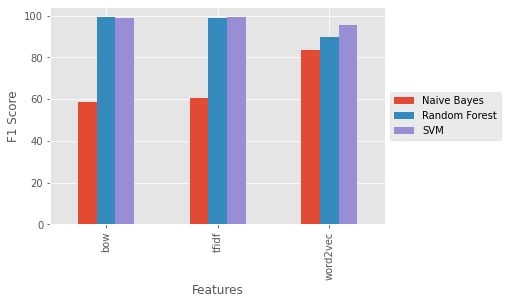

In [52]:
df_fscore = pd.DataFrame(d_fscore)
print(df_fscore)

df_fscore.transpose().plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('F1 Score')
plt.xlabel('Features')

                  bow   tfidf  word2vec
Naive Bayes     41.83   43.79     73.86
Random Forest   99.83  100.00     99.20
SVM            100.00  100.00     94.63


Text(0.5, 0, 'Features')

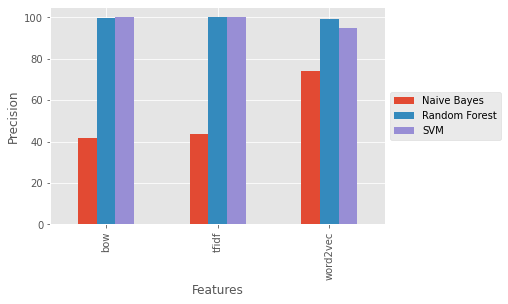

In [53]:
df_precision = pd.DataFrame(d_precision)
print(df_precision)

df_precision.transpose().plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Precision')
plt.xlabel('Features')